# Wav2Vec CTC-loss

In [1]:
import re
from types import MethodType

import torch
import torch.nn.functional as F
from evaluate import load
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from undecorated import undecorated
import matplotlib.pyplot as plt

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

In [2]:
def normalize_text(text: str):
    for char in [".", ",", "!", "?", "(", ")"]:
        text = text.replace(char, " ")
    text = text.replace("ё", "е")
    text = re.sub(" +", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    return text

In [3]:
import os
from hydra import initialize, compose
from hydra.utils import instantiate

os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name='config.yaml')
    
cfg.data.batch_size = 4

/usr/local/lib/python3.10/dist-packages/hydra/core/plugins.py:225: UserWarning: 
	Error importing 'hydra_plugins.hydra_colorlog'.
	Plugin is incompatible with this Hydra version or buggy.
	Recommended to uninstall or upgrade plugin.
		ImportError : cannot import name 'SearchPathPlugin' from 'hydra.plugins' (/usr/local/lib/python3.10/dist-packages/hydra/plugins/__init__.py)
  warnings.warn(


In [4]:
device = "cuda"

# path_model = "jonatasgrosman/wav2vec2-xls-r-1b-russian"
path_model = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
processor = Wav2Vec2Processor.from_pretrained(path_model)
model = Wav2Vec2ForCTC.from_pretrained(path_model)
model.to(device)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

In [30]:
train_loader, test_loader = instantiate(cfg.data)

Start loading datasets
Train dataset loaded
Test dataset loaded


In [31]:
batch = next(iter(test_loader))
batch

{'clean_audios': tensor([[-1.8190e-12, -5.4570e-12, -2.9104e-11,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-6.1062e-16, -1.9429e-16,  1.3878e-16,  ..., -3.6380e-12,
          -7.2760e-12,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-8.1855e-12,  5.4570e-12, -1.0914e-11,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 'noise_audios': tensor([[ 0.0211, -0.0188,  0.0160,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0102, -0.0037, -0.0042,  ..., -0.0021,  0.0102,  0.0073],
         [-0.0019,  0.0071,  0.0005,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0115,  0.0110, -0.0187,  ...,  0.0000,  0.0000,  0.0000]]),
 'clean_attention_masks': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'noise_attention_masks': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
   

In [32]:
from torchmetrics.text import WordErrorRate, CharErrorRate

wer = WordErrorRate()
cer = CharErrorRate()

### orig code, do_normalize = True

In [33]:
all_predicted_sentences = []
all_target_sentences = []

for batch in test_loader:
    inputs = processor(batch["noise_audios"], sampling_rate=16_000, return_tensors="pt", padding=True, do_normalize=True)
    attention_mask = batch["noise_attention_masks"]

    with torch.no_grad():
        logits = model(inputs.input_values.squeeze(0).to(device), attention_mask=attention_mask.to(device)).logits
        # logits = model(inputs.input_values.squeeze(0).to(device)).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    predicted_sentences = processor.batch_decode(predicted_ids)
    
    all_predicted_sentences.extend(predicted_sentences) 
    all_target_sentences.extend(batch["transcriptions"])

In [34]:
all_predicted_sentences = [normalize_text(sentence) for sentence in all_predicted_sentences]
all_target_sentences = [normalize_text(sentence) for sentence in all_target_sentences]

wer(preds=all_predicted_sentences, target=all_target_sentences), cer(preds=all_predicted_sentences, target=all_target_sentences)

(tensor(0.5498), tensor(0.2643))

In [35]:
inputs["input_values"], batch["noise_audios"], all_predicted_sentences[-4:], all_target_sentences[-4:]

(tensor([[[-0.4719,  0.2601,  0.3686,  ...,  0.0030,  0.0030,  0.0030],
          [-0.0017,  0.0427,  0.4391,  ...,  0.0030,  0.0030,  0.0030],
          [-0.3339, -0.3737, -0.4912,  ...,  0.0030,  0.0030,  0.0030],
          [ 0.1425, -0.1589,  0.1167,  ...,  0.1631,  0.1396,  0.1680]]]),
 tensor([[-0.0192,  0.0104,  0.0148,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0002,  0.0016,  0.0176,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0136, -0.0152, -0.0200,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0056, -0.0065,  0.0046,  ...,  0.0065,  0.0055,  0.0067]]),
 ['это что же тихо спросила ольга',
  'иолай отведи почки ридса в анбар',
  'аня жай ма тушка казала ней со вздохом',
  'однако как и другие я хотел бы кратко разъяснить позиции турции по реформе совета'],
 ['это что же  тихо спросила ольга',
  'юлай отведи башкирца в анбар',
  'поезжай матушка  сказал он ей со вздохом',
  'однако как и другие я хотел бы кратко разъяснить позицию турции по реформе совета'])

(tensor(10.2365), tensor(-10.1078), tensor(0.0026), tensor(0.9664))

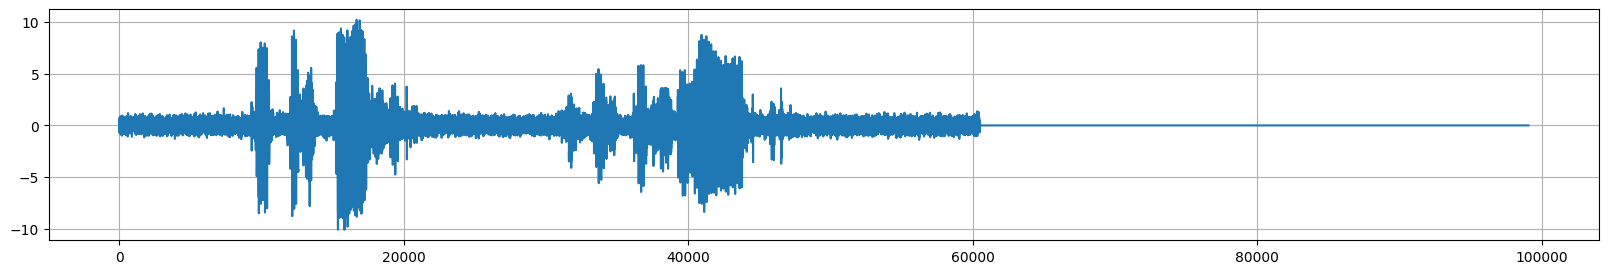

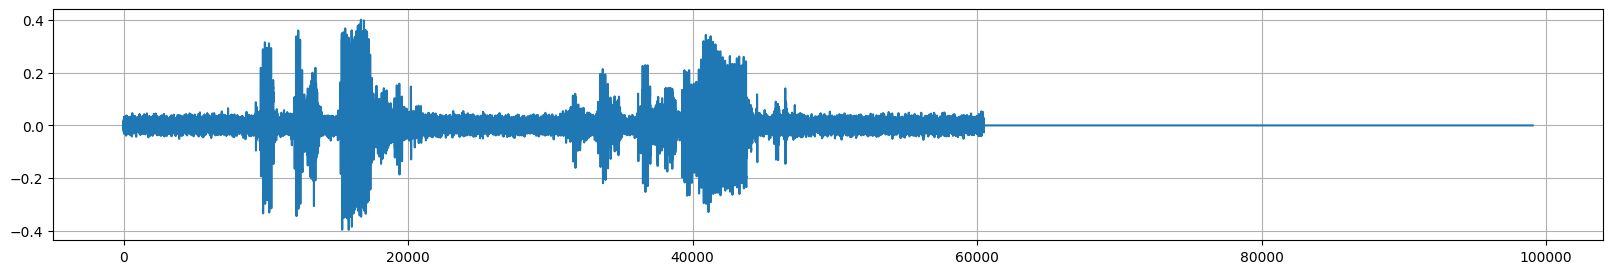

In [20]:
plt.figure(figsize=(20, 3))
plt.plot(inputs["input_values"].squeeze(0)[0].numpy())
plt.grid()

plt.figure(figsize=(20, 3))
plt.plot(batch["noise_audios"][0].numpy())
plt.grid()

a = inputs["input_values"].squeeze(0)[0]
a.max(), a.min(), a.mean(), a.std()

### orig code, do_normalize = False

In [21]:
all_predicted_sentences = []
all_target_sentences = []

for batch in test_loader:
    inputs = processor(batch["noise_audios"], sampling_rate=16_000, return_tensors="pt", padding=False, do_normalize=False)
    attention_mask = batch["noise_attention_masks"]

    with torch.no_grad():
        logits = model(inputs.input_values.squeeze(0).to(device), attention_mask=attention_mask.to(device)).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    predicted_sentences = processor.batch_decode(predicted_ids)
    
    all_predicted_sentences.extend(predicted_sentences) 
    all_target_sentences.extend(batch["transcriptions"])

In [22]:
all_predicted_sentences = [normalize_text(sentence) for sentence in all_predicted_sentences]
all_target_sentences = [normalize_text(sentence) for sentence in all_target_sentences]

wer(preds=all_predicted_sentences, target=all_target_sentences), cer(preds=all_predicted_sentences, target=all_target_sentences)

(tensor(0.5585), tensor(0.2660))

In [23]:
inputs["input_values"], batch["noise_audios"], all_predicted_sentences[-4:]

(tensor([[[ 0.3566,  0.7556, -0.1610,  ...,  0.0029,  0.0029,  0.0029],
          [-0.2467, -0.1648,  0.0771,  ...,  0.0029,  0.0029,  0.0029],
          [ 0.0790, -0.0898,  0.1841,  ...,  0.0029,  0.0029,  0.0029],
          [ 0.0619, -0.0835,  0.0429,  ...,  0.2342,  0.2277, -0.3368]]]),
 tensor([[ 0.0141,  0.0301, -0.0065,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0100, -0.0067,  0.0030,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0030, -0.0037,  0.0072,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0024, -0.0035,  0.0016,  ...,  0.0092,  0.0090, -0.0136]]),
 ['это что же тихно спросила ольга',
  'иулой отведи башке ридса в анбар',
  'аня жай ма тушка казал он ей со вздохом',
  'однако как и другие я хотел бы кратко разъяснуть позиции турций то реформе совета'])

In [58]:
speech = batch["noise_audios"] 

(speech - speech.mean()) / (speech.std() +1e-7), inputs["input_values"]

(tensor([[ 0.5185, -0.0437,  0.1134,  ...,  0.0025,  0.0025,  0.0025],
         [-0.0254,  0.1931, -0.1088,  ...,  0.0025,  0.0025,  0.0025],
         [ 0.0457, -0.0640,  0.3824,  ...,  0.0025,  0.0025,  0.0025],
         [-0.7582,  0.2034, -0.1895,  ...,  0.6056,  0.2101,  0.0479]]),
 tensor([[[ 0.5185, -0.0437,  0.1134,  ...,  0.0025,  0.0025,  0.0025],
          [-0.0254,  0.1931, -0.1088,  ...,  0.0025,  0.0025,  0.0025],
          [ 0.0457, -0.0640,  0.3824,  ...,  0.0025,  0.0025,  0.0025],
          [-0.7582,  0.2034, -0.1895,  ...,  0.6056,  0.2101,  0.0479]]]))

(tensor(10.3124), tensor(-8.4167), tensor(0.0018), tensor(1.1473))

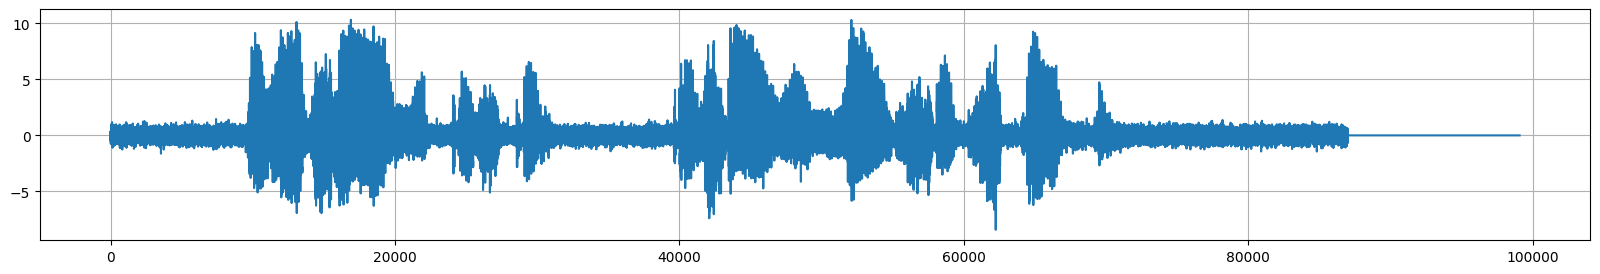

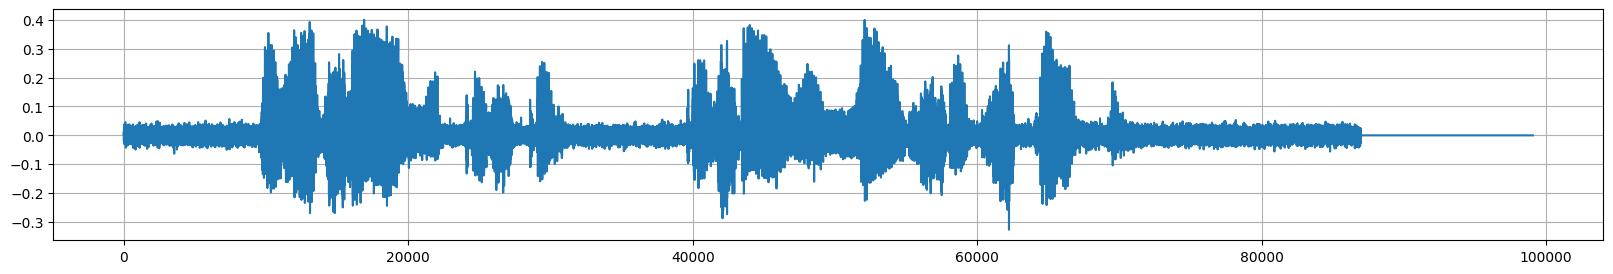

In [55]:
ind = 2

a = inputs["input_values"].squeeze(0)[ind]

plt.figure(figsize=(20, 3))
plt.plot(a.numpy())
plt.grid()

plt.figure(figsize=(20, 3))
plt.plot(batch["noise_audios"][ind].numpy())
plt.grid()

a.max(), a.min(), a.mean(), a.std()

# our code

In [59]:
all_predicted_sentences = []
all_target_sentences = []

for batch in test_loader:
    inputs = batch["noise_audios"]
    # inputs = (inputs - inputs.mean()) / (inputs.std() +1e-7) # normalize
    
    attention_mask = batch["noise_attention_masks"]
    
    with torch.no_grad():
        output = model(inputs.to(device), attention_mask=attention_mask.to(device))

    tokens_logits = output.logits
    predicted_ids = torch.argmax(tokens_logits, dim=-1)
    pred_texts = processor.batch_decode(predicted_ids)

    all_predicted_sentences.extend(pred_texts) 
    all_target_sentences.extend(batch["transcriptions"])

In [60]:
all_predicted_sentences = [normalize_text(sentence) for sentence in all_predicted_sentences]
all_target_sentences = [normalize_text(sentence) for sentence in all_target_sentences]

wer(preds=all_predicted_sentences, target=all_target_sentences), cer(preds=all_predicted_sentences, target=all_target_sentences)

(tensor(0.5524), tensor(0.2627))

In [72]:
batch["noise_audios"], all_predicted_sentences[-4:]

(tensor([[-5.9320e-03,  8.0317e-03, -5.1590e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.6071e-03,  1.4870e-02, -9.1729e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.8608e-02,  1.0596e-03,  1.5189e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 7.5932e-03, -1.9252e-03, -5.0157e-05,  ..., -3.0758e-02,
           2.2991e-02,  5.3683e-03]]),
 ['это что же тихо спросила ольга',
  'ило отвели башкирца в андар',
  'а я чай матушка касал он ей с обзестловком',
  'однако как и другие я хотел бы кратко разлистуть позиций поуципу реформы совета'])

In [30]:
clear = batch["clean_audios"].to(device)
noisy = batch["noise_audios"].to(device)

clear_mask = batch["clean_attention_masks"].to(device)
noisy_mask = batch["noise_attention_masks"].to(device)

target = batch["transcriptions"]
target = [normalize_text(t) for t in target]
# target = [i.lower() for i in target]
target

['к сожалению эти предложения не нашли отражения в тексте',
 'если не будет возражений я буду считать что ассамблея согласна с этим предложением',
 'новошахтинск  милый город',
 'мы особенно рады отметить что число скрывающихся от правосудия лиц уменьшилось']

In [31]:
# output = model(noisy.to(device), attention_mask=clear_mask.to(device))
# output = model(clear.to(device), attention_mask=clear_mask.to(device))
# tokens_logits = output.logits

In [32]:
# pred_ids = torch.argmax(tokens_logits, dim=-1)
# text = processor.batch_decode(pred_ids)
# pred_ids, pred_ids.shape, text

In [33]:
# (pred_ids == 5).sum()

In [44]:
processor.tokenizer.pad_token_id

0

In [41]:
target_ids = processor(text=target, padding=True, return_tensors="pt").input_ids
# target_ids[target_ids == 0] = -100  
target_ids, target_ids.shape, target

(tensor([[17,  4, 24, 21, 13,  7, 18, 12, 20, 15, 37,  4, 36, 25, 15,  4, 22, 23,
          12, 11, 18, 21, 13, 12, 20, 15, 38,  4, 20, 12,  4, 20,  7, 31, 18, 15,
           4, 21, 25, 23,  7, 13, 12, 20, 15, 38,  4,  9,  4, 25, 12, 17, 24, 25,
          12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [12, 24, 18, 15,  4, 20, 12,  4,  8, 26, 11, 12, 25,  4,  9, 21, 14, 23,
           7, 13, 12, 20, 15, 16,  4, 38,  4,  8, 26, 11, 26,  4, 24, 30, 15, 25,
           7, 25, 35,  4, 30, 25, 21,  4,  7, 24, 24,  7, 19,  8, 18, 12, 38,  4,
          24, 21, 10, 18,  7, 24, 20,  7,  4, 24,  4, 36, 25, 15, 19,  4, 22, 23,
          12, 11, 18, 21, 13, 12, 20, 15, 12, 19],
         [20, 21,  9, 21, 31,  7, 28, 25, 15, 20, 24, 17,  4,  4, 19, 15, 18, 34,
          16,  4, 10, 21, 23, 21, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [42]:
processor.batch_decode(target_ids)

['к сожалению эти предложения не нашли отражения в тексте',
 'если не будет возражений я буду считать что асамблея согласна с этим предложением',
 'новошахтинск милый город',
 'мы особено рады отметить что число скрывающихся от правосудия лиц уменьшилось']

In [13]:
processor.tokenizer.get_vocab()

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 '-': 5,
 'ё': 6,
 'а': 7,
 'б': 8,
 'в': 9,
 'г': 10,
 'д': 11,
 'е': 12,
 'ж': 13,
 'з': 14,
 'и': 15,
 'й': 16,
 'к': 17,
 'л': 18,
 'м': 19,
 'н': 20,
 'о': 21,
 'п': 22,
 'р': 23,
 'с': 24,
 'т': 25,
 'у': 26,
 'ф': 27,
 'х': 28,
 'ц': 29,
 'ч': 30,
 'ш': 31,
 'щ': 32,
 'ъ': 33,
 'ы': 34,
 'ь': 35,
 'э': 36,
 'ю': 37,
 'я': 38}

In [14]:
output = model(noisy.to(device), attention_mask=clear_mask.to(device), labels=target_ids.to(device))

In [15]:
pred_ids = torch.argmax(output.logits, dim=-1)
target, processor.batch_decode(pred_ids)

(['К сожалению, эти предложения не нашли отражения в тексте.',
  'Если не будет возражений, я буду считать, что Ассамблея согласна с этим предложением.',
  'Новошахтинск — милый город',
  'Мы особенно рады отметить, что число скрывающихся от правосудия лиц уменьшилось.'],
 ['к сожаление эти презложения  ни насли отражения деть',
  'если не блудит возражений я буду считать чита сбеесогласкосопредлажение',
  'на вошафке кмилый город',
  'нномсона нарадодалось что число тоуше тет полочемже ужит сотранившесь'])

In [20]:
output.loss

tensor(3.2643, device='cuda:0', grad_fn=<MeanBackward0>)

# Обкатка Wav2VecEnv

In [16]:
import random
import numpy as np
import torch

seed = 42

# Set the seed for numpy random number generator
np.random.seed(seed)

# Set the seed for python random number generator
random.seed(seed)

# Set the seed for pytorch random number generator
torch.manual_seed(seed)

# Set the seed for pytorch random number generator for CUDA
torch.cuda.manual_seed(seed)

# Set the seed for pytorch random number generator for CUDA algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [17]:
import os
from hydra import initialize, compose
from hydra.utils import instantiate

os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name='config.yaml')
    
cfg.data.batch_size = 5

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [18]:
asr = instantiate(cfg.asr)

InstantiationException: Error locating target 'dasr.asr.wav2vec.Wav2VecEnv', set env var HYDRA_FULL_ERROR=1 to see chained exception.
full_key: asr

In [ ]:
train_loader, test_loader = instantiate(cfg.data)

Start loading datasets
Train dataset loaded
Test dataset loaded


In [ ]:
batch = next(iter(test_loader))
len(batch), batch

(5,
 {'clean_audios': tensor([[-1.8190e-12, -5.4570e-12, -2.9104e-11,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-6.1062e-16, -1.9429e-16,  1.3878e-16,  ..., -3.6380e-12,
           -7.2760e-12,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-8.1855e-12,  5.4570e-12, -1.0914e-11,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 4.1473e-10,  3.7107e-10, -2.9104e-11,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]),
  'noise_audios': tensor([[ 0.0029,  0.0207,  0.0045,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0082,  0.0014,  0.0076,  ...,  0.0056, -0.0085,  0.0042],
          [-0.0141,  0.0045, -0.0161,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0231, -0.0175, -0.0098,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0029,  0.0117, -0.0030,  ...,  0.0000,  0.0000,  0.0000]]),
  'clean_attention_masks': tensor([[1., 1., 1.,  ..., 0., 0., 0.]

In [ ]:
gt_transcripts = batch["transcriptions"]

noise_audios =  batch["noise_audios"].to(asr.device)
clean_audios =  batch["clean_audios"].to(asr.device)
clean_attention_masks =  batch["clean_attention_masks"].to(asr.device)
noise_attention_masks =  batch["noise_attention_masks"].to(asr.device)

In [ ]:
pred_text, logprob = asr.inference_with_grad(noise_audios, attention_mask=noise_attention_masks)

In [ ]:
pred_text

['к сожалению эти предложения инастиотраженият детсть',
 'если не бугит возражений я буду считаться читасобое соглаското предлажение',
 'но вошавки смилый город',
 'мусона навазазасё что число толуше теат поочемжедится сосенившис',
 'в контролер']

In [ ]:
logprob

tensor([-20.8593, -32.5701,  -9.1103, -63.5105,  -1.3433], device='cuda:0')

In [ ]:
pred_text = asr.inference_without_grad(noise_audios, attention_mask=noise_attention_masks)

In [ ]:
loss, stats = asr.get_loss(noise_audios, clean_audios)

In [ ]:
loss, stats

(tensor(0.8831, device='cuda:0'),
 {'asr_loss': 0.8830564618110657,
  'reward': 0.34085825085639954,
  'logprob': -2.023484945297241,
  'wer (ref-denoisy)': 0.9032258064516129,
  'cer (ref-denoisy)': 0.48672566371681414})

In [ ]:
stats = asr.eval(noise_audios, clean_audios,noisy_speech=noise_audios, gt_transcript=gt_transcripts)
stats

{'asr_loss': 0.8830564618110657,
 'reward': 0.34085825085639954,
 'logprob': -2.023484945297241,
 'wer (ref-denoisy)': 0.9032258064516129,
 'cer (ref-denoisy)': 0.48672566371681414,
 'wer (gt-ref)': 0.7837837837837838,
 'cer (gt-ref)': 0.37349397590361444,
 'wer (gt-denoisy)': 0.5945945945945946,
 'cer (gt-denoisy)': 0.36947791164658633,
 'wer (gt-noisy)': 0.7837837837837838,
 'cer (gt-noisy)': 0.37349397590361444}

In [ ]:
from torchmetrics.text import WordErrorRate, CharErrorRate
from evaluate import load

Matplotlib created a temporary cache directory at /tmp/matplotlib-a3lwa25h because the default path (/home/docker_current/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
class TruncatedWER(WordErrorRate):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, preds, target, trunc_threshold=1):
        orig_wer = super().__call__(preds, target)
        trunc_wer = orig_wer if orig_wer != float("inf") else trunc_threshold
        return trunc_wer
    
    
class TruncatedCER(CharErrorRate):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, preds, target, trunc_threshold=1):
        orig_cer = super().__call__(preds, target)
        trunc_cer = orig_cer if orig_cer != float("inf") else trunc_threshold
        return trunc_cer

In [ ]:
torch_wer = WordErrorRate()

trunc_wer = TruncatedWER()
trunc_cer = TruncatedCER()

wer = load("wer")

In [ ]:
pred = ["hello world w w w "]
gt = [""]

In [ ]:
trunc_wer(preds=pred, target=gt), trunc_cer(preds=pred, target=gt)

(1, 1)

In [ ]:
cur_wer = torch_wer(preds=pred, target=gt)
cur_wer = cur_wer if cur_wer != float("inf") else 1
cur_wer

tensor(2.)

tensor(2.)

In [ ]:
wer.compute(predictions=pred, references=gt)

2.0

# Тестирование wav2vec и подсчет logprob как в whisper-е 

In [ ]:
import re
from types import MethodType

import torch
import torch.nn.functional as F
from evaluate import load
from transformers import WhisperForConditionalGeneration, WhisperProcessor
from undecorated import undecorated

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

In [ ]:
device = "cuda"

# path_model = "jonatasgrosman/wav2vec2-xls-r-1b-russian"
path_model = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
processor = Wav2Vec2Processor.from_pretrained(path_model)
model = Wav2Vec2ForCTC.from_pretrained(path_model)
model.to(device)

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

In [ ]:
import os
from hydra import initialize, compose
from hydra.utils import instantiate

os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

with initialize(version_base=None, config_path="configs"):
    cfg = compose(config_name='config.yaml')
    
cfg.data.batch_size = 4

/usr/local/lib/python3.10/dist-packages/hydra/core/plugins.py:225: UserWarning: 
	Error importing 'hydra_plugins.hydra_colorlog'.
	Plugin is incompatible with this Hydra version or buggy.
	Recommended to uninstall or upgrade plugin.
		ImportError : cannot import name 'SearchPathPlugin' from 'hydra.plugins' (/usr/local/lib/python3.10/dist-packages/hydra/plugins/__init__.py)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [ ]:
train_loader, test_loader = instantiate(cfg.data)

Start loading datasets
Train dataset loaded
Test dataset loaded


In [ ]:
batch = next(iter(test_loader))
len(batch), batch

(5,
 {'clean_audios': tensor([[-1.8190e-12, -5.4570e-12, -2.9104e-11,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-6.1062e-16, -1.9429e-16,  1.3878e-16,  ..., -3.6380e-12,
           -7.2760e-12,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-8.1855e-12,  5.4570e-12, -1.0914e-11,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]),
  'noise_audios': tensor([[ 0.0088, -0.0022, -0.0058,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0100, -0.0062, -0.0130,  ..., -0.0192, -0.0233,  0.0234],
          [ 0.0019,  0.0247, -0.0104,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0249,  0.0020,  0.0067,  ...,  0.0000,  0.0000,  0.0000]]),
  'clean_attention_masks': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]),
  'noise_attention_masks': tensor([[1., 1., 1.,  

In [ ]:
clear = batch["clean_audios"].to(device)
noisy = batch["noise_audios"].to(device)

clear_mask = batch["clean_attention_masks"].to(device)
noisy_mask = batch["noise_attention_masks"].to(device)

In [ ]:
sum(clear[0] != 0), clear_mask[0].sum()

(tensor(93888, device='cuda:0'), tensor(93888., device='cuda:0'))

In [ ]:
clear.shape, noisy.shape, clear_mask.shape, noisy_mask.shape    

(torch.Size([4, 161280]),
 torch.Size([4, 161280]),
 torch.Size([4, 161280]),
 torch.Size([4, 161280]))

In [ ]:
clear.requires_grad = True

In [ ]:
# output = model(noisy.to(device), attention_mask=clear_mask.to(device))
output = model(noisy.to(device))
tokens_logits = output.logits

In [ ]:
tokens_logits.shape

torch.Size([4, 503, 39])

In [ ]:
predicted_ids = torch.argmax(tokens_logits, dim=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

In [ ]:
predicted_sentences

['к сожалению эти предложения инаспиотрожения в детст',
 'если не блугив возражений я буду считалсячитасбооесогласкотопредлажение',
 'но вошахкин смилый город',
 'ум сона наразаталсе что часло тоолше чат помчем же удитяонашлос']

In [ ]:
# loss = tokens_logits.sum() / 100000
# print(loss)

In [ ]:
# loss.backward()

In [ ]:
# clear.grad[0, -1] == 0

In [ ]:
# clear.grad

In [ ]:
# for grad, mask in zip(clear.grad, clear_mask):
#     print(sum(grad != 0), mask.sum())

In [ ]:
# clear_mask

In [ ]:
# tokens_logits.shape

In [ ]:
tokens_logits[0]

tensor([[ 17.1300, -18.0372, -18.2351,  ...,  -6.7580,  -6.5762,  -3.5652],
        [ 17.3947, -18.2073, -18.4026,  ...,  -6.9610,  -6.4344,  -3.2173],
        [ 17.6733, -18.6429, -18.8118,  ...,  -6.9705,  -6.6249,  -2.7990],
        ...,
        [ 17.7120, -18.9585, -19.1477,  ...,  -7.0143,  -6.2868,  -2.4898],
        [ 17.0750, -17.6914, -17.8905,  ...,  -6.7948,  -5.5456,  -2.6992],
        [  3.2719, -10.3905, -10.2926,  ...,  -1.8794,  -4.3546,  -2.3041]],
       device='cuda:0', grad_fn=<SelectBackward0>)

Matplotlib created a temporary cache directory at /tmp/matplotlib-jupbi7p9 because the default path (/home/docker_current/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999976,
       0.9999987 , 0.9999963 , 0.9977902 , 0.99556017, 0.6853922 ,
       0.98583984, 0.8245333 , 0.9999906 , 0.99999416, 0.99999976,
       0.99999475, 0.9999993 , 1.        , 0.9999999 , 0.9999974 ,
       0.9999988 , 0.9999876 , 0.99999976, 1.        , 1.        ,
       0.9999999 , 0.9999603 , 0.999997  , 0.9998129 , 0.99998903,
       0.9996094 , 0.9999999 , 0.99999976, 0.99999976, 0.9999999 ,
       0.9999993 , 0.99999595, 0.9999355 , 0.99998486, 0.9999999 ,
       1.        , 0.9999999 , 0.99999976, 0.99014354, 0.99999

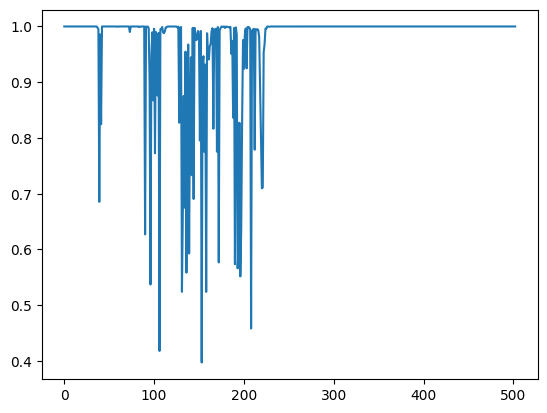

In [ ]:
from matplotlib import pyplot as plt


max_values = F.softmax(tokens_logits[0], dim=1).max(dim=1)[0].detach().cpu().numpy()

plt.figure()
plt.plot(range(len(max_values)) ,max_values)
# plt.yscale("log")
max_values

In [ ]:
tokens_logits[0].shape

torch.Size([503, 39])

In [ ]:
[sum(F.softmax(logit, dim=1).max(dim=1)[0].log()) for logit in tokens_logits]

[tensor(-16.7369, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-25.8710, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-7.5563, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-56.9715, device='cuda:0', grad_fn=<AddBackward0>)]

In [ ]:
logprobs = tokens_logits.softmax(dim=2).max(dim=2).values.log().sum(dim=1)
logprobs

tensor([-16.7369, -25.8710,  -7.5563, -56.9716], device='cuda:0',
       grad_fn=<SumBackward1>)

In [ ]:
logprobs[0]

tensor(-16.7369, device='cuda:0', grad_fn=<SelectBackward0>)

# Code fron orig repo

In [ ]:
import os
import torch
import librosa
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

os.environ["NUMBA_CACHE_DIR"] = "/tmp/"

LANG_ID = "ru"
# MODEL_ID = "jonatasgrosman/wav2vec2-xls-r-1b-russian"
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"

SAMPLES = 8
device = "cuda"

print("load data")
test_dataset = load_dataset("mozilla-foundation/common_voice_11_0", LANG_ID, split=f"train[:{SAMPLES}]")


print("load model")
processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)
model.to(device)

load data
load model


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elemen

In [ ]:
# Preprocessing the datasets.
# We need to read the audio files as arrays
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = librosa.load(batch["path"], sr=16_000)
    batch["speech"] = speech_array
    batch["sentence"] = batch["sentence"].upper()
    return batch

test_dataset = test_dataset.map(speech_file_to_array_fn)

In [ ]:
inputs = processor(test_dataset["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)

# with torch.no_grad():
#     logits = model(inputs.input_values.to(device), attention_mask=inputs.attention_mask.to(device)).logits

# predicted_ids = torch.argmax(logits, dim=-1)
# predicted_sentences = processor.batch_decode(predicted_ids)

In [ ]:
# len(test_dataset["speech"][0]), type(test_dataset["speech"][0])

In [ ]:
inputs.attention_mask.shape, inputs.input_values.shape

(torch.Size([8, 98496]), torch.Size([8, 98496]))

In [ ]:
# predicted_sentences

In [ ]:
inputs.input_values.requires_grad = True

In [ ]:
# logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits
logits = model(inputs.input_values.to(device), attention_mask=inputs.attention_mask.to(device)).logits

In [ ]:
logits.requires_grad

True

In [ ]:
logits.shape

torch.Size([8, 307, 39])

In [ ]:
loss = logits.sum() / 100000

In [ ]:
logits.shape

torch.Size([8, 307, 39])

In [ ]:
loss

tensor(-3.7543, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
loss.backward()

In [ ]:
inputs.input_values

tensor([[-1.9675e-03, -1.9675e-03, -1.9675e-03,  ..., -1.9595e-03,
         -1.9793e-03, -1.9851e-03],
        [ 4.8387e-04,  4.8387e-04,  4.8387e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.7899e-04,  3.7899e-04,  3.7899e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-3.7224e-04, -3.7224e-04, -3.7224e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.1801e-04, -5.1801e-04, -5.1801e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.3776e-06,  3.3778e-06,  3.3777e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], requires_grad=True)

In [ ]:
inputs.input_values.grad.mean()

tensor(7.7247e-06)

In [ ]:
predicted_ids = torch.argmax(logits, dim=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

In [ ]:
predicted_sentences

['демократия неумалимо продвигается по африке и арабская весна была е кульминацией',
 'доклад международного агентства по атомной амирки',
 'мы разъясняем им их права и законы',
 'только что завершилось председательство литвы сообществе демократий',
 'ведь буфет до последнего человека разом боился в залу',
 'в развитии континента достигнут знучительный прогресс',
 'это позволит спасть еще больше жизней в предстоящие годы',
 'бангладеш каждый год в первую субботу непрямо отмечем национальный день кооперативы']

In [ ]:
predicted_ids

tensor([[0, 0, 0,  ..., 0, 0, 4],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 4, 0, 0]], device='cuda:0')

In [ ]:
len(predicted_sentences[0])

80

In [ ]:
predicted_ids.shape

torch.Size([8, 307])

In [ ]:
processor.tokenizer.get_vocab()

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 '-': 5,
 'ё': 6,
 'а': 7,
 'б': 8,
 'в': 9,
 'г': 10,
 'д': 11,
 'е': 12,
 'ж': 13,
 'з': 14,
 'и': 15,
 'й': 16,
 'к': 17,
 'л': 18,
 'м': 19,
 'н': 20,
 'о': 21,
 'п': 22,
 'р': 23,
 'с': 24,
 'т': 25,
 'у': 26,
 'ф': 27,
 'х': 28,
 'ц': 29,
 'ч': 30,
 'ш': 31,
 'щ': 32,
 'ъ': 33,
 'ы': 34,
 'ь': 35,
 'э': 36,
 'ю': 37,
 'я': 38}